# Customer Segmentation in Retail Industry

## Background

Dalam transaksi jual beli, customer memiliki peran penting dalam eksistensi dan kemajuan sebuah industri. Oleh karenanya berbagai strategi marketing dilakukan untuk menarik perhatian customer baru atau untuk mempertahankan loyalitas customer. 
Cara yang paling umum dilakukan adalah pemberian diskon pada product tertentu atau pemberian free product untuk customer tertentu. Strategi marketing ini diterapkan sesuai dengan value yang dimiliki oleh customer. Beberapa value dapat dikategorikan menjadi `low-value customer` (customer dengan frekuensi transaksi rendah dan *spend money* rendah), `medium-value customer` (customer dengan frekuensi transaksi tinggi namun *spend money* rendah atau sebaliknya), dan `high-value customer` (customer dengan frekuensi transaksi tinggi dan *spend money* yang tinggi pula).

Dalam melakukan segmentasi customer ada beberapa faktor yang harus dipertimbangkan. Faktor tersebut umumnya dianalisis berdasarkan data historical transaksi yang dimiliki oleh customer. Dari data historical tersebut dilakukan analisis lebih lanjut untuk mengetahui pattern data dan kemudian dilakukan modelling dengan bantuan algoritma machine learning agar menghasilkan output yang dapat dipertanggungjawabkan. Rangkaian proses ini nantinya diharapkan dapat menjawab beberapa pertanyaan bisnis seperti : 
`Siapakah customer yang berpotensi untuk *churn*`, `Siapakah loyal customer`, `Siapakah potential customer`, dan lain-lain.

Metode segmentasi yang paling umum digunakan untuk melakukan segmentasi customer adalah RFM analysis. RFM akan melakukan segmentasi berdasarkan 3 poin penting yaitu :

1. Recency : Waktu transaksi terakhir yang dilakukan customer
2. Frequency : Banyak transaksi yang dilakukan oleh customer
3. Monetary : Banyak uang yang dikeluarkan ketika melakukan transaksi

Dalam artikel ini, akan dibahas lebih lanjut tentang proses segmentasi customer menggunakan metode RFM dengan bantuan machine learning clustering algorithm. Bahasa yang digunakan adalah bahasa pemrograman python.

<img src='assets/RFM.png' width=600 height=600/>

## Modelling Analysis

Pada artikel ini data yang digunakan adalah data online retail di UK yang dapat ditemukan pada [link berikut](https://www.kaggle.com/carrie1/ecommerce-data). Data ini adalah data transaksi yang terjadi pada 01/12/2010 sampai 09/12/2011.

### Import Library and Read Data

In [69]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [70]:
ecom = pd.read_csv("data_input/data_ecom_uk.csv",encoding='latin1')

In [71]:
ecom.head(2)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [72]:
ecom.shape

(541909, 8)

Dataframe ini mengandung 541909 observasi dengan jumlah kolom sebanyak 8 yang antara lain adalah :

* InvoiceNo : Nomor invoice yang terdiri dari 6 digit angka unik. Ketika `InvoiceNo` diawali dengan character `C` maka mengindikasikan *cancellation transaction*.
* StockCode : Kode product yang terdiri dari 5 digit angka unik.
* Description : Deskripsi nama product.
* Quantity : Jumlah product yang dibeli pada setiap transaksi.
* InvoiceDate : Tanggal transaksi berlangsung.
* UnitPrice : Harga satuan product.
* CustomerID : ID Customer yang berisi 5 digit angka unik dan berbeda pada setiap customer.
* Country : Nama negara.

### Get only transaction in UK

Dikarenakan terdapat beberapa data yang tidak berada pada country United Kingdom (UK), maka perlu dilakukan filter data hanya untuk country daerah UK.

In [73]:
ecom_uk = ecom[ecom['Country']=='United Kingdom']
ecom_uk.shape

(495478, 8)

In [74]:
ecom_uk.head(2)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


### Handle Missing Values

Missing value adalah masalah yang umum dihadapi ketika melakukan proses pengolahan data. Missing value terjadi ketika terdapat obeservasi kosong pada sebuah data. 

Pada hasil di bawah ini dapat diketahui informasi bahwa beberapa variable pada data menggandung nilai missing, variable tersebut antara lain adalah `Description` dan `CustomerID`. `CustomerID` adalah variable penting dalam RFM analisis, dikarenakan `CustomerID` mengandung informasi unik ID member. Sedangkan `Description` mengandung informasi terkait deskripsi produk. Jika ditelaah lebih jauh, untuk menangani missing values pada kedua variable tersebut dapat dilakukan dengan cara *deletion*, dikarenakan proses imputasi pada kedua variable tersebut akan menghasilkan informasi yang tidak akurat.


In [75]:
ecom_uk.isna().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     133600
Country             0
dtype: int64

Berikut ini adalah proses penghapusan missing values pada data :

In [77]:
ecom_uk.dropna(inplace=True)

<ipython-input-77-61026bac6ee0>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ecom_uk.dropna(inplace=True)


### Select Unique Transaction

Duplicated values atau duplikasi data adalah nilai berulang pada satu atau lebih observasi. Untuk menangani data yang duplikat dapat dilakukan penghapusan dan hanya mempertahankan salah satu observasi.

In [80]:
ecom_uk.drop_duplicates(subset=['InvoiceNo', 'CustomerID'], keep="first", inplace=True)

<ipython-input-80-15e9cec117e5>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ecom_uk.drop_duplicates(subset=['InvoiceNo', 'CustomerID'], keep="first", inplace=True)


### Change Data Types

Dalam pengolahan data transformasi tipe data pada format yang sesuai sangat penting untuk dilakukan, hal ini agar nantinya data-data tersebut siap untuk dilakukan manipulasi lebih lanjut.

In [81]:
ecom_uk.dtypes

InvoiceNo       object
StockCode       object
Description     object
Quantity         int64
InvoiceDate     object
UnitPrice      float64
CustomerID     float64
Country         object
dtype: object

In [82]:
ecom_uk['InvoiceDate'] = pd.to_datetime(ecom_uk['InvoiceDate'])
ecom_uk['Country'] = ecom_uk['Country'].astype('category')
ecom_uk['CustomerID'] = ecom_uk['CustomerID'].astype('int64')

<ipython-input-82-cf31e1a1847b>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ecom_uk['InvoiceDate'] = pd.to_datetime(ecom_uk['InvoiceDate'])
<ipython-input-82-cf31e1a1847b>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ecom_uk['Country'] = ecom_uk['Country'].astype('category')
<ipython-input-82-cf31e1a1847b>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https

### Drop cancelled transaction

Karakter pertama "C" pada `InvoiceNo` menunjukkan bahwa customer melakukan pembatalan terhadap transaksi yang dilakukan. Sehingga data akan kurang relevan jika tetap dipertahankan, maka dari itu perlu dilakukan penghapusan pada observasi tersebut.

In [83]:
ecom_uk = ecom_uk.loc[~ecom_uk.iloc[:,0].str.contains(r'C')]

In [84]:
ecom_uk.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom
7,536366,22633,HAND WARMER UNION JACK,6,2010-12-01 08:28:00,1.85,17850,United Kingdom
9,536367,84879,ASSORTED COLOUR BIRD ORNAMENT,32,2010-12-01 08:34:00,1.69,13047,United Kingdom
21,536368,22960,JAM MAKING SET WITH JARS,6,2010-12-01 08:34:00,4.25,13047,United Kingdom
25,536369,21756,BATH BUILDING BLOCK WORD,3,2010-12-01 08:35:00,5.95,13047,United Kingdom


## Exploratory Data Analysis

Tahapan Exploratory Data Analysis digunakan untuk mengetahui pattern dari data.

### Recency

Recency adalah faktor yang menyimpan informasi tentang berapa lama sejak customer melakukan pembelian. Untuk melakukan perhitungan recency pada masing-masing customer dapat dilakukan dengan cara memanipulasi tanggal transaksi customer dan kemudian dikurangi dengan tanggal maksimum yang terdapat pada data. Berikut di bawah ini adalah detail langkah-langkahnya :

a. Manipulasi tanggal transaksi dengan mengekstrak informasi tanggal, bulan dan tahun transaksi.

In [85]:
ecom_uk['Date'] = ecom_uk['InvoiceDate'].dt.date

In [86]:
ecom_uk.head(2)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Date
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,2010-12-01
7,536366,22633,HAND WARMER UNION JACK,6,2010-12-01 08:28:00,1.85,17850,United Kingdom,2010-12-01


b. Mengambil tanggal transaksi maksimum pada keseluruhan observasi

In [87]:
last_trans = ecom_uk['Date'].max()
last_trans

datetime.date(2011, 12, 9)

c. Mengekstrak informasi tanggal transaksi maksimum pada tiap customer.

In [88]:
recent = ecom_uk.groupby(by=['CustomerID'],  as_index=False)['Date'].max()

In [89]:
recent.columns = ['CustomerID','Last Transaction']
recent.head()

,CustomerID,Last Transaction
0,12346,2011-01-18
1,12747,2011-12-07
2,12748,2011-12-09
3,12749,2011-12-06
4,12820,2011-12-06


d. Menghitung selisih tanggal transaksi maksimum dengan tanggal transaksi terakhir pada tiap customer, kemudian menyimpan jumlah hari pada kolom `Days Recent`.

In [90]:
recent['Days Recent'] = last_trans - recent['Last Transaction']
recent['Days Recent'] = recent['Days Recent'].dt.days

In [91]:
recent.head()

,CustomerID,Last Transaction,Days Recent
0,12346,2011-01-18,325
1,12747,2011-12-07,2
2,12748,2011-12-09,0
3,12749,2011-12-06,3
4,12820,2011-12-06,3


In [92]:
recent.drop(columns=['Last Transaction'], inplace=True)

### Frequency

Frequency mengandung infromasi tentang seberapa sering customer melakukan transaksi pembelian dalam kurun waktu tertentu. Nilai frequency dapat diperoleh dengan cara menghitung jumlah transkasi pada setiap unik customer.

In [97]:
temp = ecom_uk[['CustomerID','InvoiceNo']]

In [98]:
trans_cust = temp.groupby(by=['CustomerID']).count()
trans_cust.rename(columns={'InvoiceNo':'Number of Transaction'})
trans_cust.reset_index()

,CustomerID,InvoiceNo
0,12346,1
1,12747,11
2,12748,210
3,12749,5
4,12820,4
...,...,...
3916,18280,1
3917,18281,1
3918,18282,2
3919,18283,16


Ouptut di atas menunjukkan jumlah transaksi yang dilakukan pada masing-masing customer. CustomerID 12346 melakukan transaksi sebanyak 1 kali saja, CustomerID 12747 melakukan transaksi sebanyak 11 kali, dan seterusnya.

Berikut dibawah ini adalah detail informasi `InvoiceNo` pada setiap transaksi yang dilakukan oleh customer.

In [99]:
table_trans_details = temp.groupby(by=['CustomerID','InvoiceNo']).count()

In [100]:
table_trans_details.head()

Empty DataFrame
Columns: []
Index: [(12346, 541431), (12747, 537215), (12747, 538537), (12747, 541677), (12747, 545321)]

### Monetary

Monetary adalah faktor yang menyimpan jumlah pengeluaran customer dalam transaksi. Nilai monetary dapat dihitung dari harga barang yang dibeli oleh masing-masing customer pada transaksi tertentu dan kemudian dikalkulasikan dengan jumlah barang yang dibeli.

In [101]:
ecom_uk['Total'] = ecom_uk['UnitPrice'] * ecom_uk['Quantity']
ecom_uk.head(2)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Date,Total
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,2010-12-01,15.3
7,536366,22633,HAND WARMER UNION JACK,6,2010-12-01 08:28:00,1.85,17850,United Kingdom,2010-12-01,11.1


In [102]:
monetary = ecom_uk.groupby(by=['CustomerID'], as_index=False)['Total'].sum()

In [103]:
monetary

,CustomerID,Total
0,12346,77183.60
1,12747,689.49
2,12748,3841.31
3,12749,98.35
4,12820,58.20
...,...,...
3916,18280,23.70
3917,18281,5.04
3918,18282,38.25
3919,18283,66.75


### Merge Column based on CustomerID

Setelah mendapatkan informasi pada setiap faktor penting, langkah selanjutnya adalah menyimpannya kedalam sebuah dataframe baru.

In [104]:
new_ = monetary.merge(trans_cust,on='CustomerID')
new_data = new_.merge(recent,on='CustomerID')
new_data.rename(columns={'Total':'Monetary','InvoiceNo':'Frequency','Days Recent':'Recency'}, inplace=True)
new_data.head()

,CustomerID,Monetary,Frequency,Recency
0,12346,77183.60,1,325
1,12747,689.49,11,2
2,12748,3841.31,210,0
3,12749,98.35,5,3
4,12820,58.20,4,3


## Modelling

### Clustering Recency, Frequency, and Monetary

Proses clustering bertujuan untuk membagi level customer kedalam beberapa segment tertentu meliputi `low-value customer`, `medium-value customer` or `high-value customer`.

### Recency

Pada faktor Recency, customer yang memiliki *recent* trasaksi akan di kategorikan pada `high-value customer`. Kenapa? Karena customer tersebut berpotensi untuk melakukan pembelian lagi dibanding dengan customer yang sudah lama tidak melakukan pembelian. 

In [105]:
new_data['Recency'].describe()

count    3921.000000
mean       91.722265
std        99.528532
min         0.000000
25%        17.000000
50%        50.000000
75%       142.000000
max       373.000000
Name: Recency, dtype: float64

Teknik elbow mwthod untuk menentukan jumlah cluster yang terbentuk.

<ipython-input-107-7aae48a71e8e>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recency["clusters"] = kmeans.labels_
<ipython-input-107-7aae48a71e8e>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recency["clusters"] = kmeans.labels_
<ipython-input-107-7aae48a71e8e>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_g

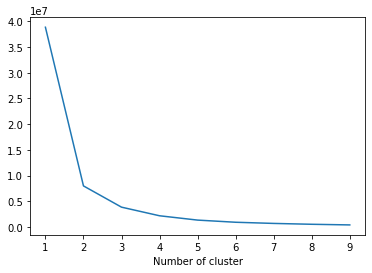

In [107]:
from sklearn.cluster import KMeans


sse={}
recency = new_data[['Recency']]
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(recency)
    recency["clusters"] = kmeans.labels_
    sse[k] = kmeans.inertia_ 
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.show()

In [108]:
kmeans = KMeans(n_clusters=3)
kmeans.fit(new_data[['Recency']])
new_data['RecencyCluster'] = kmeans.predict(new_data[['Recency']])

In [109]:
new_data.groupby('RecencyCluster')['Recency'].describe()

,count,mean,std,min,25%,50%,75%,max
RecencyCluster,,,,,,,,
0,2640.0,31.902273,25.336528,0.0,10.0,25.0,51.00,93.0
1,558.0,293.175627,45.309128,225.0,255.0,283.5,325.75,373.0
2,723.0,154.673582,37.878377,94.0,121.0,155.0,186.00,222.0


Berdasarkan visualisasi grafik elbow, maka jumlah cluster ideal yang dapat dibentuk adalah sebanyak 3 cluster. Pada hasil di atas menunjukkan bahwa cluster 1 mengandung informasi customer yang melakukan transaksi paling baru (most recent) sedangkan cluster 0 mengandung informasi customer yang sudah lama tidak melakukan transaksi pembelian. 

Untuk keperluan standarisasi, maka perlu dilakukan re-order cluster sehingga cluster 0 akan memuat informasi `low-value customer`, cluster 1 `medium-value customer` dan cluster 2 `high-value customer`.
Dikarenakan step ini adalah step Recency, maka cluster yang memiliki nilai recency rendah akan dikategorikan pada cluster 2.

Dibawah ini adalah fungsi untuk melakukan reorder cluster :

In [1]:
#function for ordering cluster numbers
def order_cluster(cluster_field_name, target_field_name,df,ascending):
    new_cluster_field_name = 'new_' + cluster_field_name
    df_new = df.groupby(cluster_field_name)[target_field_name].mean().reset_index()
    df_new = df_new.sort_values(by=target_field_name,ascending=ascending).reset_index(drop=True)
    df_new['index'] = df_new.index
    df_final = pd.merge(df,df_new[[cluster_field_name,'index']], on=cluster_field_name)
    df_final = df_final.drop([cluster_field_name],axis=1)
    df_final = df_final.rename(columns={"index":cluster_field_name})
    return df_final

In [ ]:
new_data = order_cluster('RecencyCluster', 'Recency',new_data,False)

### Frequency

Factor penting selanjutnya adalah Frequency. Pada step frequency, customer yang memiliki banyak transaksi pembelian akan dikategorikan pada level `high-value customer`.

In [111]:
new_data['Frequency'].describe()

count    3921.000000
mean        4.246111
std         7.205750
min         1.000000
25%         1.000000
50%         2.000000
75%         5.000000
max       210.000000
Name: Frequency, dtype: float64

<ipython-input-113-0656d6293a81>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  frequency["clusters"] = kmeans.labels_
<ipython-input-113-0656d6293a81>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  frequency["clusters"] = kmeans.labels_
<ipython-input-113-0656d6293a81>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/us

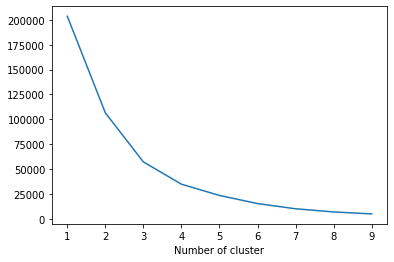

In [113]:
sse={}
frequency = new_data[['Frequency']]
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(frequency)
    frequency["clusters"] = kmeans.labels_
    sse[k] = kmeans.inertia_ 
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.show()

In [114]:
kmeans = KMeans(n_clusters=3)
kmeans.fit(new_data[['Frequency']])
new_data['FrequencyCluster'] = kmeans.predict(new_data[['Frequency']])
new_data.groupby('FrequencyCluster')['Frequency'].describe()

,count,mean,std,min,25%,50%,75%,max
FrequencyCluster,,,,,,,,
0,3701.0,3.055931,2.540346,1.0,1.0,2.0,4.00,12.0
1,214.0,21.672897,10.177095,13.0,15.0,18.0,25.00,63.0
2,6.0,116.833333,47.562240,86.0,91.5,95.0,117.25,210.0


Sama halnya dengan tahapan pada step Recency, pada step ini juga perlu dilakukan standarisasi cluster dengan melakukan reorder pada cluster. Sehingga cluster 0 dengan nilai frequency yang rendah akan dikategorikan pada level `low-value customer` sedangkan cluster 2 dengan nilai frequency tinggi akan dikategorikan pada level `high-values customer`.

In [115]:
new_data = order_cluster('FrequencyCluster', 'Frequency',new_data,True)

### Monetary

Faktor penting terakhir pada RFM analysis adalah Monetary. Customer dengan nilai monetary yang tinggi akan dikategorikan pada level `high-value customer` dikarenakan berkontribusi besar dalam pendapatan yang dihasilkan industry.

In [116]:
new_data['Monetary'].describe()

count      3921.000000
mean        293.299913
std        3261.756525
min           0.000000
25%          17.700000
50%          45.400000
75%         124.500000
max      168471.250000
Name: Monetary, dtype: float64

<ipython-input-118-63a61b3da261>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  monetary_["clusters"] = kmeans.labels_
<ipython-input-118-63a61b3da261>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  monetary_["clusters"] = kmeans.labels_
<ipython-input-118-63a61b3da261>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/us

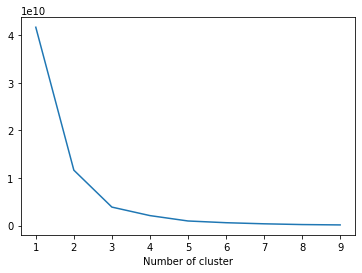

In [118]:
sse={}
monetary_ = new_data[['Monetary']]
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(monetary_)
    monetary_["clusters"] = kmeans.labels_
    sse[k] = kmeans.inertia_ 
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.show()

In [119]:
kmeans = KMeans(n_clusters=3)
kmeans.fit(new_data[['Monetary']])
new_data['MonetaryCluster'] = kmeans.predict(new_data[['Monetary']])
new_data.groupby('MonetaryCluster')['Monetary'].describe()

,count,mean,std,min,25%,50%,75%,max
MonetaryCluster,,,,,,,,
0,3914.0,189.384371,712.979643,0.00,17.5875,45.300,123.200,17895.28
1,1.0,168471.250000,NaN,168471.25,168471.2500,168471.250,168471.250,168471.25
2,6.0,40051.213333,19522.938794,24384.92,27576.6500,34958.095,41519.325,77183.60


Reorder cluster untuk standarisasi cluster sehingga cluster 0 dengan nilai monetary rendah akan dikategorikan dalam `low-value customer` sedangkan cluster 2 dengan nilai monetary tinggi akan dikelompokkan pada `high-values customer`.

In [120]:
new_data = order_cluster('MonetaryCluster', 'Monetary',new_data,True)

### Segmentation Customer based on Cluster

Setelah memperoleh nilai cluster terurut pada setiap observasi data, langkah selanjutnya adalah memberikan label pada masing-masing observasi. Label ini bertujuan untuk mengidentifikasi level pada masing-masing customer apakah tergolong pada `low-value customer`, `medium-value customer` atau `high-value customer`.

Proses pelabelan terdiri dari beberapa tahapan yang antara lain adalah :

In [121]:
new_data.head()

,CustomerID,Monetary,Frequency,Recency,RecencyCluster,FrequencyCluster,MonetaryCluster
0,12346,77183.60,1,325,0,0,1
1,15098,39916.50,3,182,1,0,1
2,16029,24384.92,63,38,2,1,1
3,17450,26768.97,46,8,2,1,1
4,17949,29999.69,45,1,2,1,1


a. Menghitung score pada masing-masing observasi dengan melakukan penjumlahan pada nilai cluster.  

In [123]:
new_data['Score'] = new_data['RecencyCluster'] + new_data['FrequencyCluster'] + new_data['MonetaryCluster']
new_data.head(2)

,CustomerID,Monetary,Frequency,Recency,RecencyCluster,FrequencyCluster,MonetaryCluster,Score
0,12346,77183.6,1,325,0,0,1,1
1,15098,39916.5,3,182,1,0,1,2


In [124]:
print(new_data['Score'].min())
print(new_data['Score'].max())

0
4


Dari hasil di atas diperoleh informasi bahwa minimum score pada data adalah 0, sedangkan maksimum value pada data adalah 4. Sehingga untuk segmentasi label dapat dikategorikan berdasarkan ketentuan berikut :

* Customer dengan score <= 1 akan masuk dalam kategori `low-value customer`
* Customer dengan score <= 3 akan masuk dalam kategori `medium-value customer`
* Customer dengan score > 3 akan masuk dalam kategori `high-value customer`

In [125]:
label = []

def label_(data) :
    if data <= 1 :
        lab = "Low"
    elif data <= 3 :
        lab = "Medium"
    else :
        lab = "High"
    label.append(lab)

In [126]:
new_data['Score'].apply(label_)

0       None
1       None
2       None
3       None
4       None
        ... 
3916    None
3917    None
3918    None
3919    None
3920    None
Name: Score, Length: 3921, dtype: object

In [127]:
new_data['Label'] = label

In [128]:
new_data.head(2)

,CustomerID,Monetary,Frequency,Recency,RecencyCluster,FrequencyCluster,MonetaryCluster,Score,Label
0,12346,77183.6,1,325,0,0,1,1,Low
1,15098,39916.5,3,182,1,0,1,2,Medium


## Customer's behavior in each factor based on their label

Setelah memberikan label pada masing-masing customer, apakah sudah cukup membantu untuk tim management dalam menentukan strategi marketing yang tepat? Jawabannya dapat Ya atau Tidak. Tidak dikarenakan management perlu untuk mengetahui informasi detail dari behavior (kebiasaan) customer pada setiap level dalam melakukan pembelanjaan. Oleh karena itu, sebelum melangkah lebih jauh, terlebih dahulu lakukan behavior analisis sebagai berikut :


In [129]:
import numpy as np

def neg_to_zero(x):
    if x <= 0:
        return 1
    else:
        return x

new_data['Recency'] = [neg_to_zero(x) for x in new_data.Recency]
new_data['Monetary'] = [neg_to_zero(x) for x in new_data.Monetary]

rfm_log = new_data[['Recency', 'Frequency', 'Monetary']].apply(np.log, axis = 1).round(3)

In [130]:
from sklearn.preprocessing import StandardScaler
    
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_log)

rfm_scaled = pd.DataFrame(rfm_scaled, index = new_data.index, columns = rfm_log.columns)

In [131]:
rfm_scaled.head()

,Recency,Frequency,Monetary
0,1.389971,-1.049966,4.788147
1,0.996792,0.170733,4.359157
2,-0.064790,3.551812,4.038228
3,-1.121628,3.203041,4.098768
4,-2.530970,3.178605,4.172979


In [132]:
rfm_scaled['Label'] = new_data.Label
rfm_scaled['CustomerID'] = new_data.CustomerID

In [133]:
rfm_scaled

,Recency,Frequency,Monetary,Label,CustomerID
0,1.389971,-1.049966,4.788147,Low,12346
1,0.996792,0.170733,4.359157,Medium,15098
2,-0.064790,3.551812,4.038228,High,16029
3,-1.121628,3.203041,4.098768,High,17450
4,-2.530970,3.178605,4.172979,High,17949
...,...,...,...,...,...
3916,-2.061189,4.031650,3.055261,High,13089
3917,-2.530970,3.984999,1.973998,High,14606
3918,-2.530970,3.960563,2.967380,High,15311
3919,-2.530970,4.303780,2.165383,High,17841


In [134]:
rfm_melted = pd.melt(frame= rfm_scaled, id_vars= ['CustomerID', 'Label'], \
                     var_name = 'Metrics', value_name = 'Value')

In [135]:
rfm_melted

,CustomerID,Label,Metrics,Value
0,12346,Low,Recency,1.389971
1,15098,Medium,Recency,0.996792
2,16029,High,Recency,-0.064790
3,17450,High,Recency,-1.121628
4,17949,High,Recency,-2.530970
...,...,...,...,...
11758,13089,High,Monetary,3.055261
11759,14606,High,Monetary,1.973998
11760,15311,High,Monetary,2.967380
11761,17841,High,Monetary,2.165383


Visualisasi behavior customer pada setiap level.

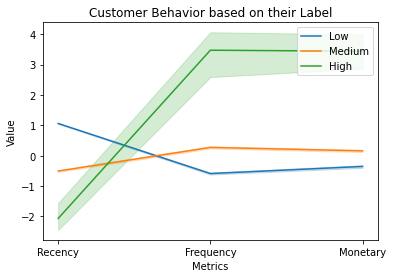

In [136]:
import seaborn as sns

# a snake plot with RFM
sns.lineplot(x = 'Metrics', y = 'Value', hue = 'Label', data = rfm_melted)
plt.title('Customer Behavior based on their Label')
plt.legend(loc = 'upper right')

Berdasarkan visualisasi di atas diperoleh detail informasi bahwa :

1. Customer dengan `high-value` labels memiliki kecenderungan untuk menghabiskan banyak uang dalam berbelanja (high monetary) dan sering melakukan pembelanjaan (high frequency)
2. Customer dengan `medium-value` labels tidak terlalu sering melakukan pembelian dan juga tidak banyak menghabiskan uang selama transaksi.
3. Customer dengan `low-value` labels hanya menghabiskan sedikit uang selama berbelanja, tidak terlalu sering berbelanja, tetapi  memiliki nilai recency yang cukup tinggi dibandingkan level lainnya.

Berdasarkan rules di atas, pihak management dapat mempertimbangkan melakukan strategi marketing dengan cara :

1. Memberikan special promotion atau discount untuk `low-value` customer yang baru-baru saja berkunjung untuk berbelanja, sehingga mereka tertarik untuk berbelanja lagi di lain waktu.
2. Mempertahankan `medium-value` customer dengan cara memberikan cashback pada pembeliannya.
3. Memberikan reward pada loyal customer (`high-value`) dengan cara memberikan free product atau cashback pada pembelanjaannya.

## Conclusion

RFM analysis adalah teknik yang umum digunakan untuk melakukan segmentasi terhadap customer berdasarkan value dan behavior selama bertransaksi. Teknik ini sangat membantu pihak management khususnya marketing team dalam menentukan strategi bisnis yang cocok untuk mempertahankan loyal customer dan menarik customer baru.